## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning==1.5.10
%matplotlib inline

## Setup imports

In [ ]:
import pytorch_lightning
from monai.utils import set_determinism
from monai.utils.enums import MetricReduction
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
    MapTransform,
    Activations,
    Activationsd,
    AsDiscreted,
    Invertd,
    NormalizeIntensityd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    EnsureTyped,
)
from monai.networks.nets import UNet,UNETR,SegResNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric,HausdorffDistanceMetric,ConfusionMatrixMetric
from monai.losses import DiceCELoss,DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, DataLoader
from monai.config import print_config
from monai.apps import download_and_extract,DecathlonDataset
from monai.handlers.utils import from_engine
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.2.dev2309
Numpy version: 1.22.4
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c846c8badc019e158780b9f017b43d923f1f85d1
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.11.2
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-rec

## Setup data directory


In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp49ryn4hf


## Download dataset

Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar"
md5 = "240a19d752f0d9e9101544901065d872"

compressed_file = os.path.join(root_dir, "Task01_BrainTumour.tar")
data_dir = os.path.join(root_dir, "Task01_BrainTumour")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task01_BrainTumour.tar: 7.09GB [03:02, 41.7MB/s]                            

2023-02-26 09:40:59,467 - INFO - Downloaded: /tmp/tmp49ryn4hf/Task01_BrainTumour.tar


2023-02-26 09:41:34,480 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-02-26 09:41:34,483 - INFO - Writing into directory: /tmp/tmp49ryn4hf.


In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d


In [ ]:
import monai


In [ ]:
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
haursdoff_values_tc = []
haursdoff_values_wt = []
haursdoff_values_et = []

## Define the LightningModule


In [ ]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        super().__init__()
        self._model = SegResNet(
            blocks_down=[1, 2, 2, 4],
            blocks_up=[1, 1, 1],
            init_filters=16,
            in_channels=4,
            out_channels=3,
            dropout_prob=0.2,
        )

        self.loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
        self.post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
        self.post_label = AsDiscrete(to_onehot=3,num_classes=3, dim=1)
        self.dice_metric = DiceMetric(include_background=False, reduction="mean")
        self.dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
        self.haursdoff = HausdorffDistanceMetric(include_background=True, distance_metric='euclidean', percentile=None, directed=False, reduction="mean_batch", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # setting up the correct data path
        train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
        train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
        data_dicts = [
            {"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)
        ]
        train_files, val_files = data_dicts[:207], data_dicts[-9:]

        # setting deterministic training for reproducibility
        set_determinism(seed=0)

        # defining the data transforms
        train_transform = Compose(
    [

        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
        val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)
        
        self.train_ds = monai.data.Dataset(
            data=train_files,
            transform= train_transform,
        )
        self.val_ds = monai.data.Dataset(
            data=val_files,
            transform= val_transform,
        )

    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_ds,
            batch_size=1,
            shuffle=True,
            num_workers=4,
            collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.val_ds, batch_size=1, num_workers=4)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (240, 240, 160)
        sw_batch_size = 1
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        self.dice_metric(y_pred=outputs, y=labels)
        self.dice_metric_batch(y_pred = outputs,y = labels)
        self.haursdoff(y_pred = outputs,y = labels)
        return {"val_loss": loss, "val_number": len(outputs)}


    def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        metric_batch = self.dice_metric_batch.aggregate()
        metric_tc = metric_batch[0].item()
        metric_values_tc.append(metric_tc)
        metric_wt = metric_batch[1].item()
        metric_values_wt.append(metric_wt)
        metric_et = metric_batch[2].item()
        metric_values_et.append(metric_et)
        haursdoff = self.haursdoff.aggregate()
        hd_tc = haursdoff[0].item()
        haursdoff_values_tc.append(hd_tc)
        hd_wt = haursdoff[1].item()
        haursdoff_values_wt.append(hd_wt)
        hd_et = haursdoff[2].item()
        haursdoff_values_et.append(hd_et)
        self.dice_metric_batch.reset()
        self.dice_metric.reset()
        self.haursdoff.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)

        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch}"
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
            f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
            f" hd_tc: {hd_tc:.4f} hd_wt:{hd_wt:.4f} hd_et:{hd_et}"
        )
        return {"log": tensorboard_logs}

## Run the training

In [ ]:
# initialising the LightningModule
net = Net()

# setting up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir)

# initialising Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs= 8,
    logger=tb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    log_every_n_steps=16,
)

# training
trainer.fit(net)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type      | Params
--------------------------------------------
0 | _model        | SegResNet | 4.7 M 
1 | loss_function | DiceLoss  | 0     
--------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


current epoch: 0current mean dice: 0.0054
best mean dice: 0.0054 at epoch: 0 tc: 0.0000 wt: 0.0100 et: 0.0007 hd_tc: 190.7485 hd_wt:183.2457 hd_et:193.3649444580078


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

current epoch: 0current mean dice: 0.2361
best mean dice: 0.2361 at epoch: 0 tc: 0.3504 wt: 0.4674 et: 0.0048 hd_tc: 88.6999 hd_wt:79.6768 hd_et:207.42335510253906


Validating: 0it [00:00, ?it/s]

current epoch: 1current mean dice: 0.3140
best mean dice: 0.3140 at epoch: 1 tc: 0.4647 wt: 0.6233 et: 0.0048 hd_tc: 80.1839 hd_wt:71.8326 hd_et:207.42335510253906


Validating: 0it [00:00, ?it/s]

current epoch: 2current mean dice: 0.3725
best mean dice: 0.3725 at epoch: 2 tc: 0.5334 wt: 0.7402 et: 0.0048 hd_tc: 76.5711 hd_wt:68.2290 hd_et:207.42335510253906


Validating: 0it [00:00, ?it/s]

current epoch: 3current mean dice: 0.4154
best mean dice: 0.4154 at epoch: 3 tc: 0.6096 wt: 0.7340 et: 0.0967 hd_tc: 41.2959 hd_wt:71.2837 hd_et:192.04554748535156


Validating: 0it [00:00, ?it/s]

current epoch: 4current mean dice: 0.5203
best mean dice: 0.5203 at epoch: 4 tc: 0.7255 wt: 0.8251 et: 0.2156 hd_tc: 20.2370 hd_wt:51.2842 hd_et:81.0618896484375


Validating: 0it [00:00, ?it/s]

current epoch: 5current mean dice: 0.5666
best mean dice: 0.5666 at epoch: 5 tc: 0.7506 wt: 0.8761 et: 0.2571 hd_tc: 12.5935 hd_wt:22.6943 hd_et:33.51087951660156


Validating: 0it [00:00, ?it/s]

current epoch: 6current mean dice: 0.5523
best mean dice: 0.5666 at epoch: 5 tc: 0.8014 wt: 0.8539 et: 0.2507 hd_tc: 13.4675 hd_wt:24.7234 hd_et:37.00122833251953


Validating: 0it [00:00, ?it/s]

current epoch: 7current mean dice: 0.5476
best mean dice: 0.5666 at epoch: 5 tc: 0.8470 wt: 0.8456 et: 0.2495 hd_tc: 20.7771 hd_wt:52.1644 hd_et:70.55792999267578


In [ ]:
print(f"train completed, best_metric: {net.best_val_dice:.4f} " f"at epoch {net.best_val_epoch}")

train completed, best_metric: 0.5666 at epoch 5


## Check best model output with the input image and label

torch.Size([1, 3, 240, 240, 155])


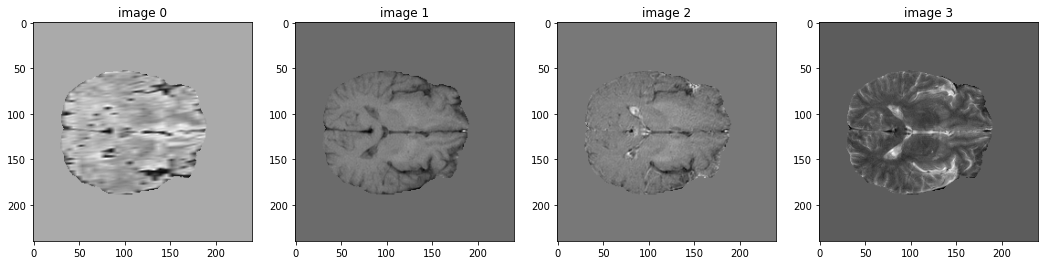

torch.Size([1, 3, 240, 240, 155])


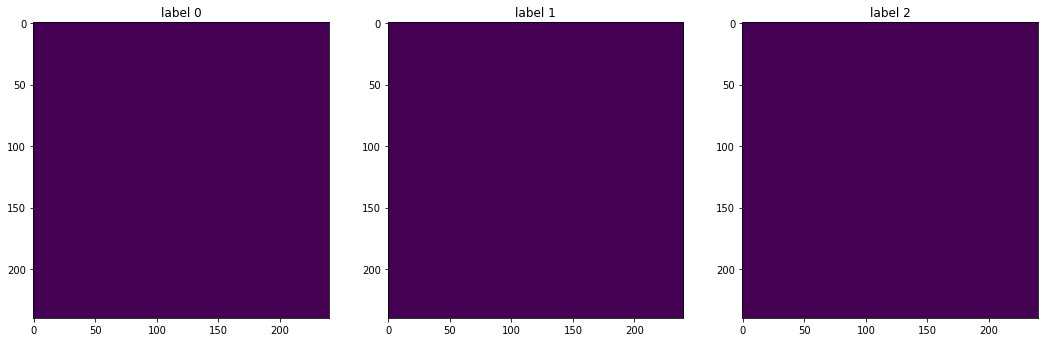

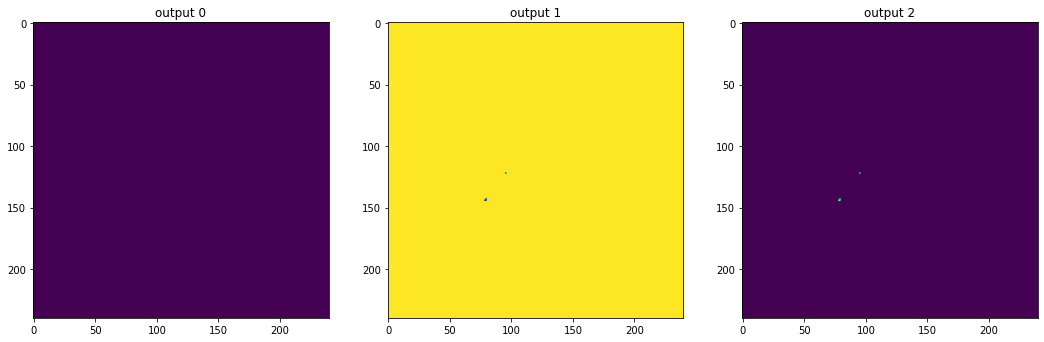

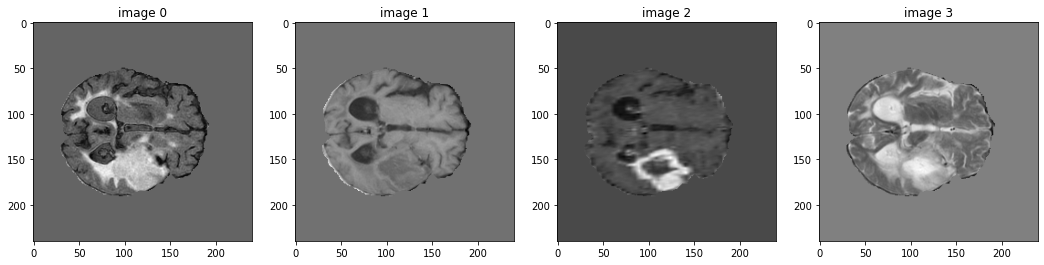

torch.Size([1, 3, 240, 240, 155])


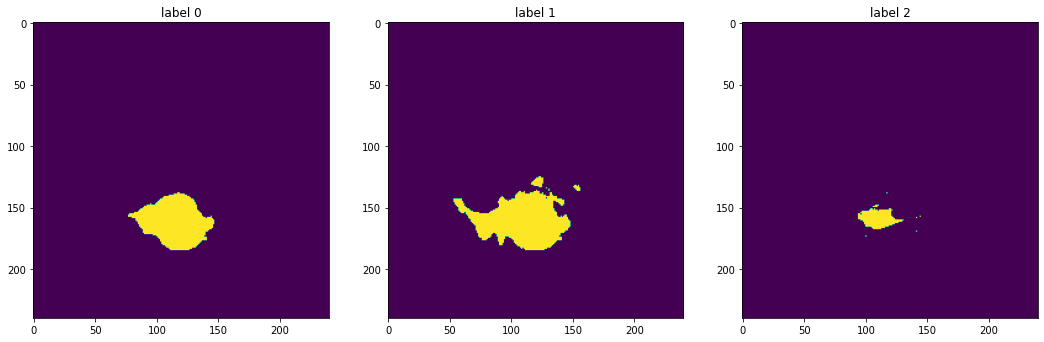

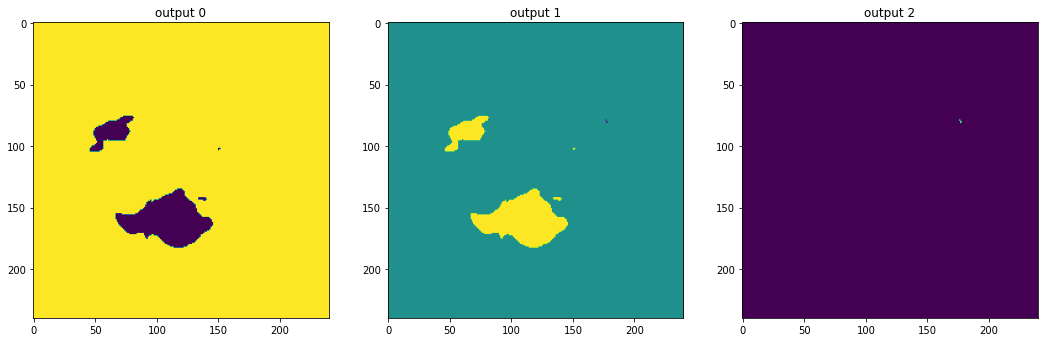

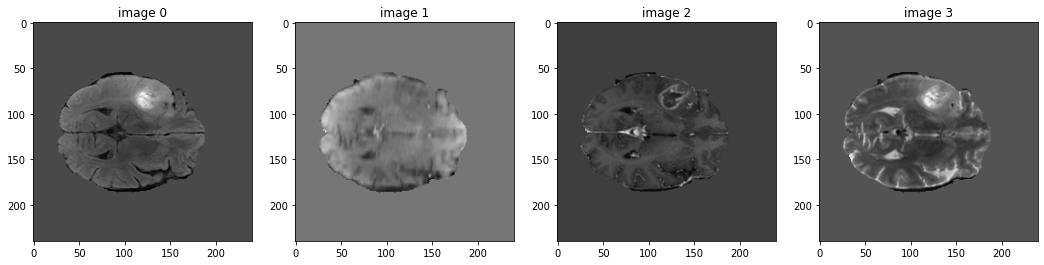

torch.Size([1, 3, 240, 240, 155])


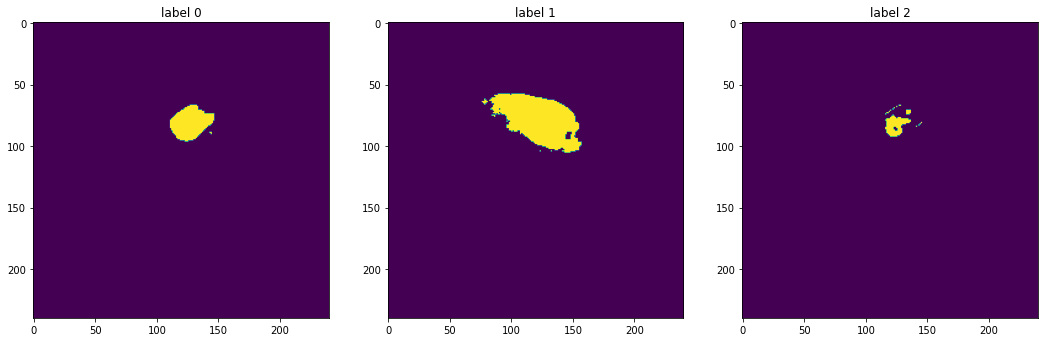

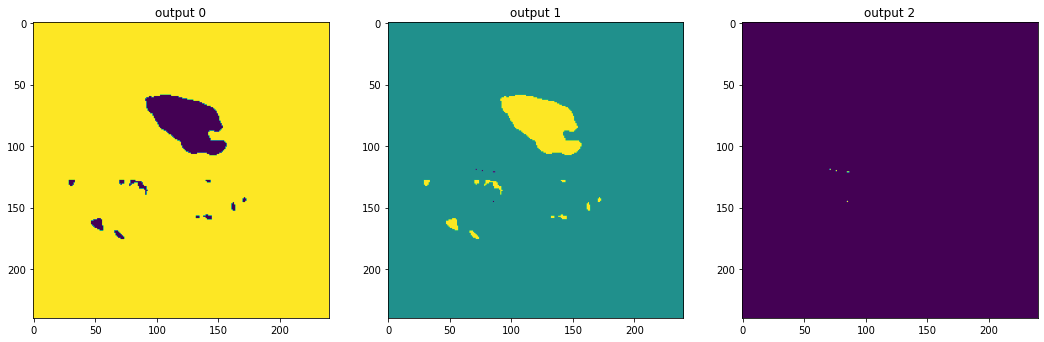

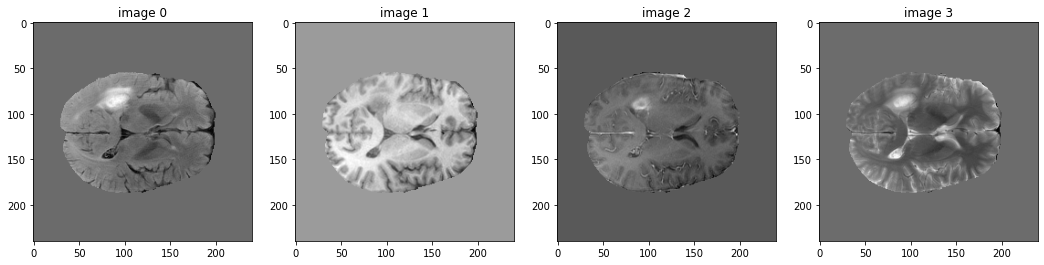

torch.Size([1, 3, 240, 240, 155])


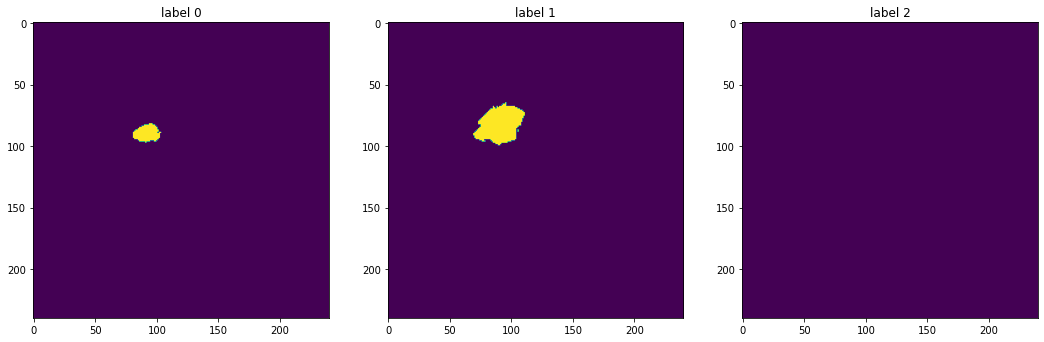

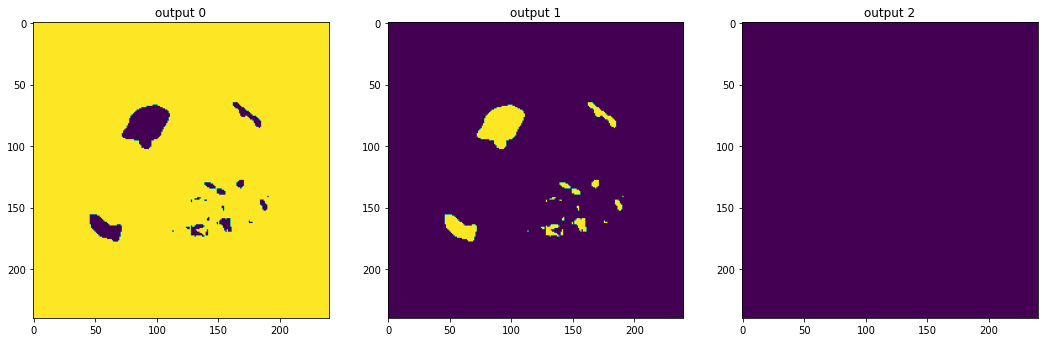

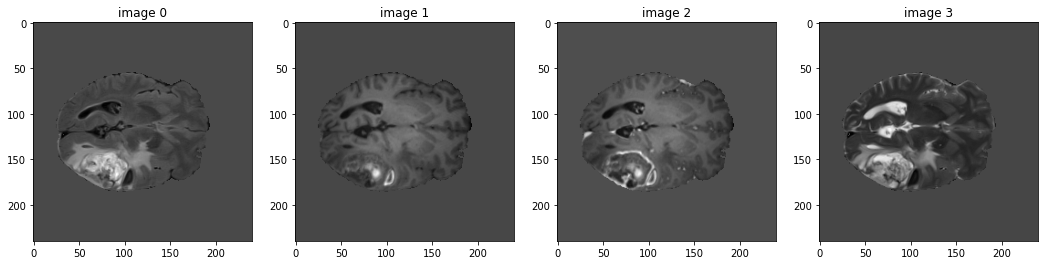

torch.Size([1, 3, 240, 240, 155])


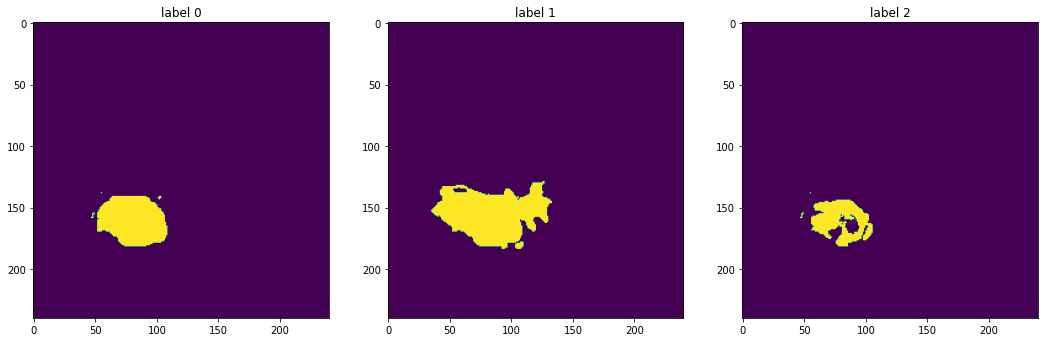

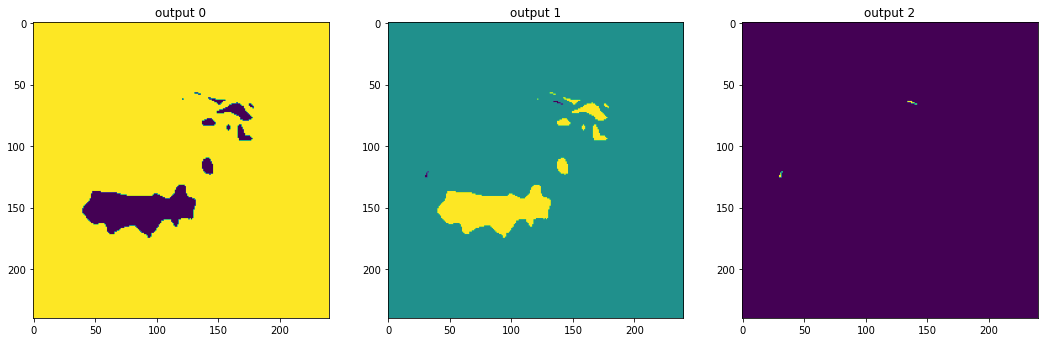

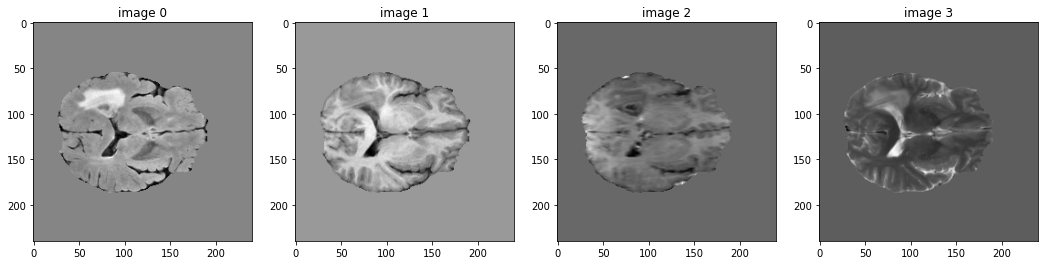

torch.Size([1, 3, 240, 240, 155])


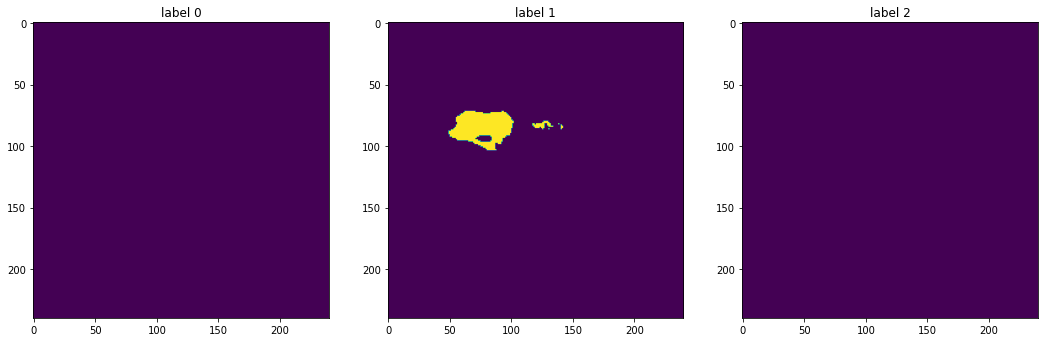

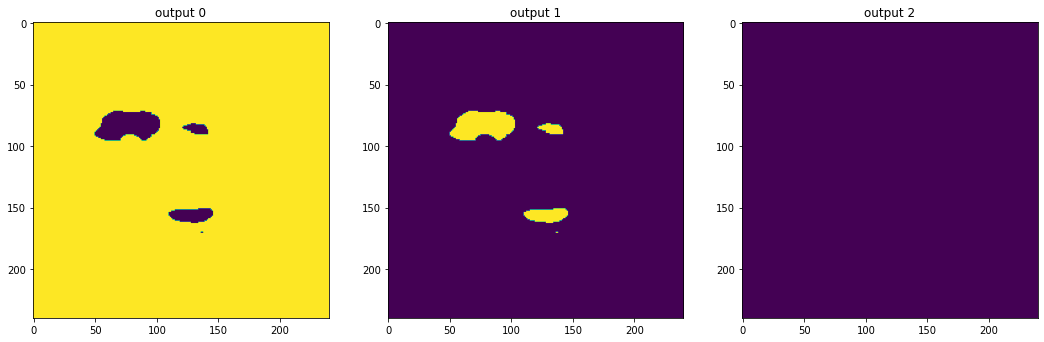

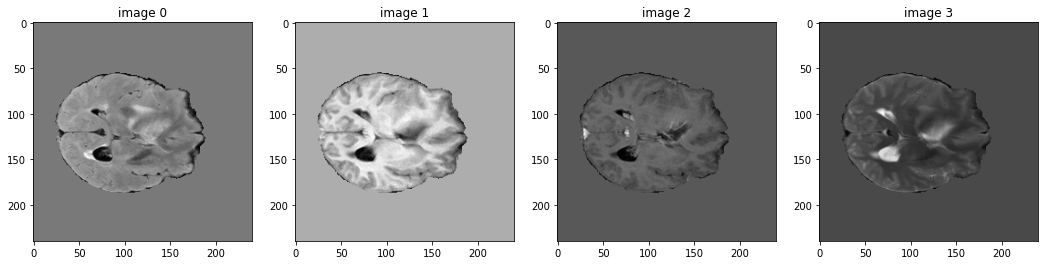

torch.Size([1, 3, 240, 240, 155])


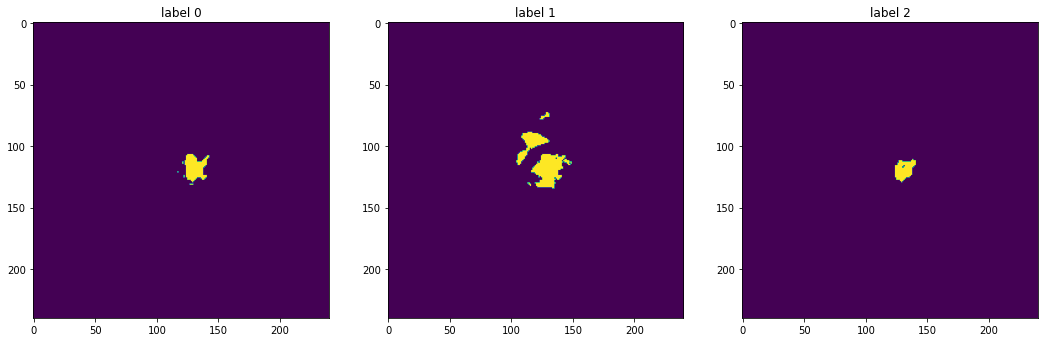

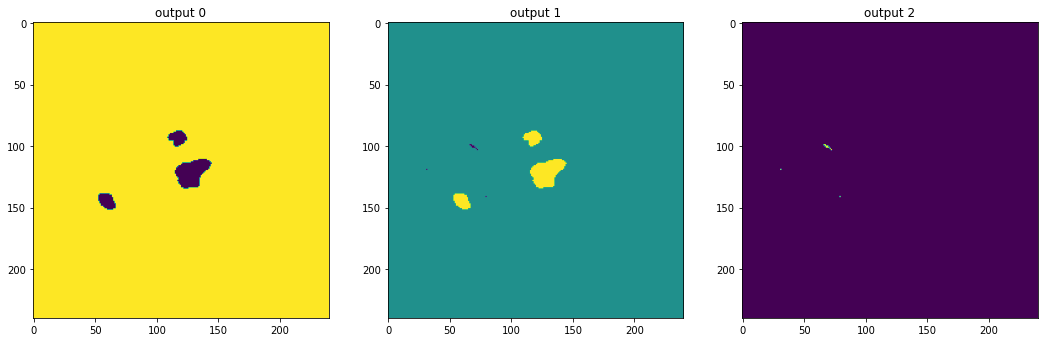

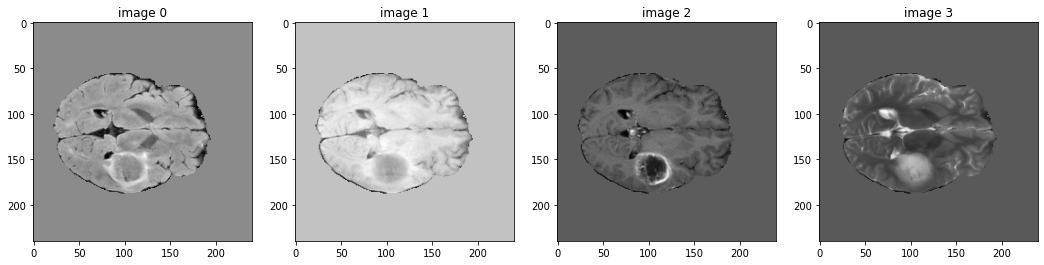

torch.Size([1, 3, 240, 240, 155])


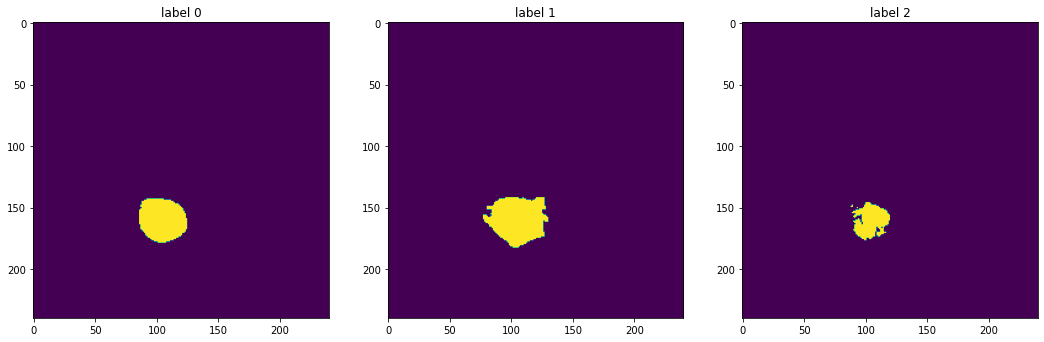

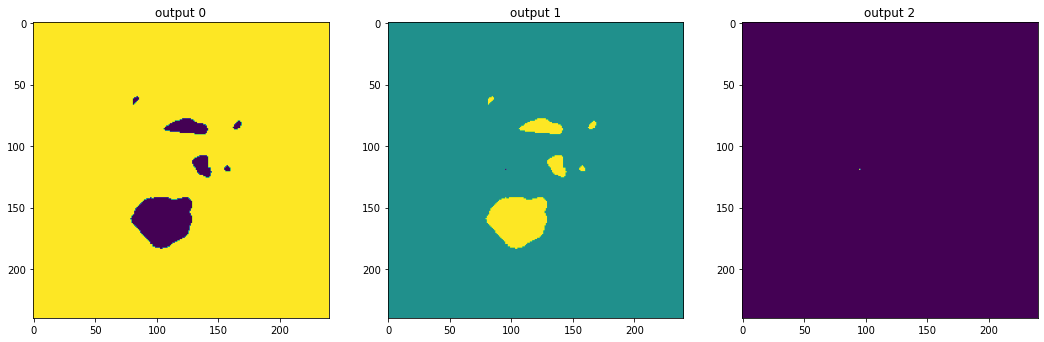

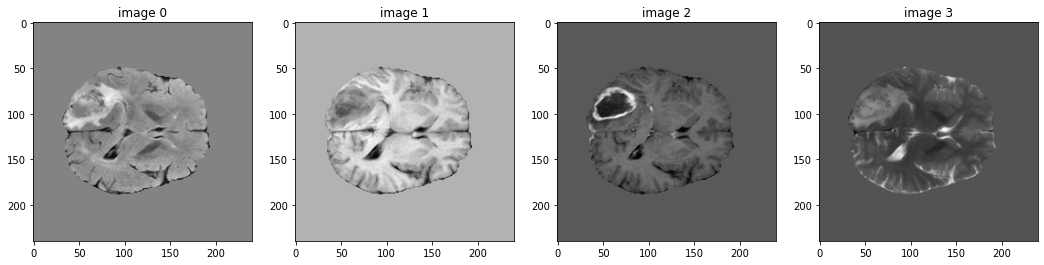

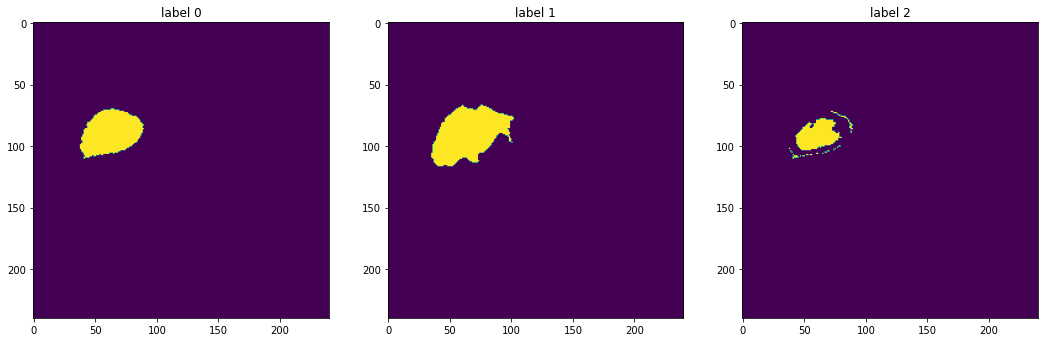

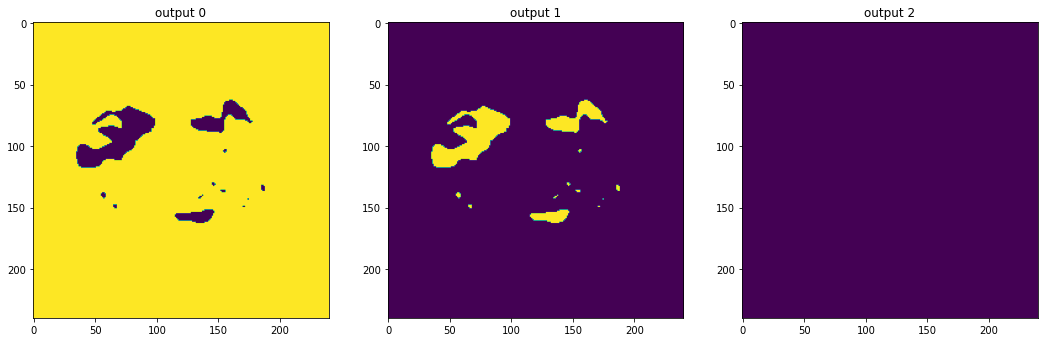

In [ ]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (128, 128, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, net)
        print(val_data["label"].shape)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        for j in range(4):
            plt.subplot(1, 4, j + 1)
            plt.title(f"image {j}")
            plt.imshow(val_data["image"][0, j, :, :, 70], cmap="gray")
        plt.show()
        plt.figure("label", (18, 6))
        for k in range(3):
            plt.subplot(1, 3, k + 1)
            plt.title(f"label {k}")
            plt.imshow(val_data["label"][0, k, :, :, 70])
        plt.figure("output",(18,6))    
        for l in range (3):
            plt.subplot(1, 3, l + 1)   
            plt.title(f"output {l}")
            plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0,:, :, 70])
            argmax_indices = torch.argmax(val_outputs, dim=1)
            val_outputs.scatter_(1, argmax_indices.unsqueeze(1), float('-inf'))

      
            

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
model = Net()

In [ ]:
filepath = "Model.pt"

In [ ]:
torch.save(model.state_dict(),filepath)